# Group Number: 32

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries


In [31]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [32]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [33]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [34]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [35]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [36]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

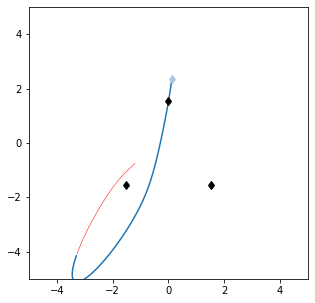

Charges are [-0.45503458 -0.12434963 -0.12960364]


In [37]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

## Data Handling and Preprocessing

In [38]:
import torch.nn.functional as f
import torch

lengths_train = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_train))).unsqueeze(-1)
lengths_valid = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_valid))).unsqueeze(-1)
lengths_test = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_test))).unsqueeze(-1)


simulation_train = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_train)))
simulation_valid = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_valid)))
simulation_test = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_test)))


simulation_continued_train = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_train)))
simulation_continued_valid = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_valid)))
simulation_continued_test = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_test)))


charges_train = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_train)))
charges_valid = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_valid)))
charges_test = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_test)))

In [39]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset_31 = TensorDataset(simulation_train, charges_train)
valid_dataset_31 = TensorDataset(simulation_valid, charges_valid)
test_dataset_31 = TensorDataset(simulation_test, charges_test)

train_dataset_32 = TensorDataset(simulation_train[:simulation_continued_train.shape[0]], simulation_continued_train, lengths_train)
valid_dataset_32 = TensorDataset(simulation_valid[:simulation_continued_valid.shape[0]], simulation_continued_valid, lengths_valid)
test_dataset_32 = TensorDataset(simulation_test[:simulation_continued_test.shape[0]], simulation_continued_test, lengths_test)

In [40]:
batch_size = 64

train_dataloader_31 = DataLoader(train_dataset_31, batch_size=batch_size, shuffle=True)
valid_dataloader_31 = DataLoader(valid_dataset_31, batch_size=batch_size, shuffle=False)
test_dataloader_31 = DataLoader(test_dataset_31, batch_size=batch_size, shuffle=False)

train_dataloader_32 = DataLoader(train_dataset_32, batch_size=batch_size, shuffle=True)
valid_dataloader_32 = DataLoader(valid_dataset_32, batch_size=batch_size, shuffle=False)
test_dataloader_32 = DataLoader(test_dataset_32, batch_size=batch_size, shuffle=False)

# Task 3.1

## Model Implementation

In [111]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
        self.embedding = nn.Sequential(nn.Linear(coord_shape, emb_dim),
                                       nn.Dropout(dropout))
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first = True)
        
    def forward(self, x):
        
        x = self.embedding(x)
        _, (hidden, cell) = self.rnn(x)

        return hidden, cell



In [112]:
class SequenceToCharge(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout,
                 output_shape):
        super(SequenceToCharge, self).__init__()

        self.encoder = Encoder(coord_shape, emb_dim, hid_dim, n_layers, dropout)

        self.dense = nn.Sequential(nn.Linear(hid_dim, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_shape),
                                   nn.Sigmoid()
                                  )

    def forward(self, particle_trajectory):
        hidden, _ = self.encoder(particle_trajectory)
        output = self.dense(hidden[-1])

        return output - 1

## Model Training

In [113]:
from tqdm import tqdm

class Trainer31():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                sequence, charges = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(sequence)  # one forward pass

                loss += self.criterion(out, charges)  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                sequence, charges = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(sequence)  # one forward pass
                    loss += self.criterion(out, charges)  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self):

        self.model.eval()

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.testing_DataLoader:
                
                sequence, charges = x.float().to(self.device), y.float().to(self.device)
                out = self.model(sequence)
                loss.append(self.criterion(out, charges))
                
        print(f'Error: {np.mean(loss):.4f}')

## Evaluation

In [114]:
if torch.cuda.is_available():
        device = torch.device('cuda')
else:
        device=torch.device('cpu')

model = SequenceToCharge(coord_shape = 2, emb_dim = 8, hid_dim = 16, n_layers = 1, dropout = 0.5, 
                         output_shape = 3).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer31(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader_31,
                                valid_dataloader_31,
                                test_dataloader_31,
                                epochs = 25)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

  4%|███▎                                                                               | 1/25 [00:00<00:09,  2.55it/s]

EPOCH: 01/25 LOSS: 0.0806 VAL-LOSS: 0.0877


  8%|██████▋                                                                            | 2/25 [00:00<00:09,  2.49it/s]

EPOCH: 02/25 LOSS: 0.0780 VAL-LOSS: 0.0882


 12%|█████████▉                                                                         | 3/25 [00:01<00:09,  2.39it/s]

EPOCH: 03/25 LOSS: 0.0774 VAL-LOSS: 0.0847


 16%|█████████████▎                                                                     | 4/25 [00:01<00:08,  2.41it/s]

EPOCH: 04/25 LOSS: 0.0741 VAL-LOSS: 0.0825


 20%|████████████████▌                                                                  | 5/25 [00:02<00:08,  2.33it/s]

EPOCH: 05/25 LOSS: 0.0733 VAL-LOSS: 0.0785


 24%|███████████████████▉                                                               | 6/25 [00:02<00:08,  2.37it/s]

EPOCH: 06/25 LOSS: 0.0710 VAL-LOSS: 0.0854


 28%|███████████████████████▏                                                           | 7/25 [00:02<00:07,  2.31it/s]

EPOCH: 07/25 LOSS: 0.0713 VAL-LOSS: 0.0658


 32%|██████████████████████████▌                                                        | 8/25 [00:03<00:07,  2.30it/s]

EPOCH: 08/25 LOSS: 0.0747 VAL-LOSS: 0.0832


 36%|█████████████████████████████▉                                                     | 9/25 [00:03<00:07,  2.25it/s]

EPOCH: 09/25 LOSS: 0.0717 VAL-LOSS: 0.0798


 40%|████████████████████████████████▊                                                 | 10/25 [00:04<00:06,  2.25it/s]

EPOCH: 10/25 LOSS: 0.0647 VAL-LOSS: 0.0729


 44%|████████████████████████████████████                                              | 11/25 [00:04<00:05,  2.36it/s]

EPOCH: 11/25 LOSS: 0.0597 VAL-LOSS: 0.0757


 48%|███████████████████████████████████████▎                                          | 12/25 [00:05<00:05,  2.26it/s]

EPOCH: 12/25 LOSS: 0.0570 VAL-LOSS: 0.0610


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:05<00:05,  2.34it/s]

EPOCH: 13/25 LOSS: 0.0532 VAL-LOSS: 0.0664


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:05<00:04,  2.35it/s]

EPOCH: 14/25 LOSS: 0.0509 VAL-LOSS: 0.0627


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:06<00:04,  2.38it/s]

EPOCH: 15/25 LOSS: 0.0473 VAL-LOSS: 0.0594


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:06<00:03,  2.35it/s]

EPOCH: 16/25 LOSS: 0.0435 VAL-LOSS: 0.0468


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:07<00:03,  2.28it/s]

EPOCH: 17/25 LOSS: 0.0405 VAL-LOSS: 0.0629


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:07<00:03,  2.28it/s]

EPOCH: 18/25 LOSS: 0.0386 VAL-LOSS: 0.0457


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:08<00:02,  2.33it/s]

EPOCH: 19/25 LOSS: 0.0357 VAL-LOSS: 0.0505


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:08<00:02,  2.36it/s]

EPOCH: 20/25 LOSS: 0.0354 VAL-LOSS: 0.0586


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:08<00:01,  2.47it/s]

EPOCH: 21/25 LOSS: 0.0350 VAL-LOSS: 0.0365


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:09<00:01,  2.44it/s]

EPOCH: 22/25 LOSS: 0.0332 VAL-LOSS: 0.0510


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:09<00:00,  2.47it/s]

EPOCH: 23/25 LOSS: 0.0320 VAL-LOSS: 0.0496


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:10<00:00,  2.44it/s]

EPOCH: 24/25 LOSS: 0.0318 VAL-LOSS: 0.0418


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.36it/s]

EPOCH: 25/25 LOSS: 0.0304 VAL-LOSS: 0.0428
Error: 0.0356


### Look at the errors

In [115]:
predicted_charges = model(simulation_test)
indices = np.argsort(((predicted_charges - charges_test)**2).sqrt().mean(axis = 1).detach().numpy())[-5:]

Predicted Charges: tensor([-0.2674, -0.3334, -0.7627]), Actual Charges: tensor([-0.4411, -0.0729, -0.2845])
The length of the given sequence: 94


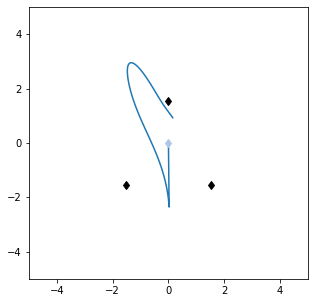

In [116]:
print(f'Predicted Charges: {predicted_charges[indices[0]].detach()}, Actual Charges: {charges_test[indices[0]]}')
print(f'The length of the given sequence: {((simulation_test[indices[0]] != 0).sum(axis = 1) > 0).sum().item()}')
plot_example(simulation_test[indices[0]])

Predicted Charges: tensor([-0.6271, -0.5096, -0.2462]), Actual Charges: tensor([-0.1228, -0.0967, -0.2784])
The length of the given sequence: 93


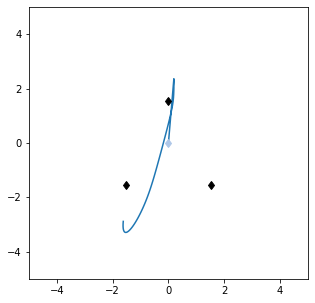

In [117]:
print(f'Predicted Charges: {predicted_charges[indices[1]].detach()}, Actual Charges: {charges_test[indices[1]]}')
print(f'The length of the given sequence: {((simulation_test[indices[1]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[1]])

Predicted Charges: tensor([-0.5069, -0.6182, -0.2958]), Actual Charges: tensor([-0.0670, -0.1208, -0.2702])
The length of the given sequence: 96


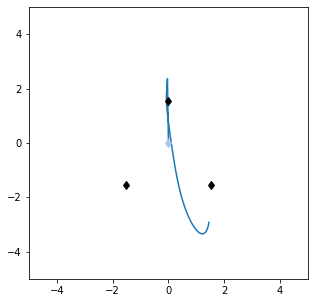

In [118]:
print(f'Predicted Charges: {predicted_charges[indices[2]].detach()}, Actual Charges: {charges_test[indices[2]]}')
print(f'The length of the given sequence: {((simulation_test[indices[2]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[2]])

Predicted Charges: tensor([-0.2883, -0.4894, -0.8547]), Actual Charges: tensor([-0.2563, -0.1709, -0.1958])
The length of the given sequence: 94


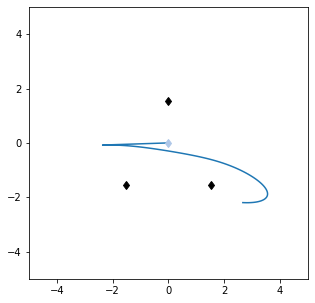

In [119]:
print(f'Predicted Charges: {predicted_charges[indices[3]].detach()}, Actual Charges: {charges_test[indices[3]]}')
print(f'The length of the given sequence: {((simulation_test[indices[3]] != 0).sum(axis = 1) > 0).sum().item()}')
plot_example(simulation_test[indices[3]])

Predicted Charges: tensor([-0.4851, -0.7160, -0.7267]), Actual Charges: tensor([-0.1193, -0.3966, -0.3992])
The length of the given sequence: 94


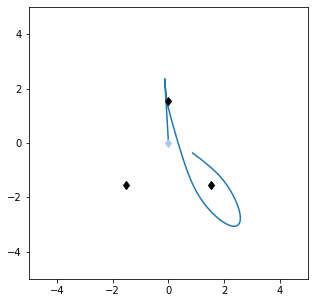

In [120]:
print(f'Predicted Charges: {predicted_charges[indices[4]].detach()}, Actual Charges: {charges_test[indices[4]]}')
print(f'The length of the given sequence: {((simulation_test[indices[4]] != 0).sum(axis = 1) > 0).sum().item()}')
plot_example(simulation_test[indices[4]])

#### The most precisely predicted examples

In [121]:
indices = np.argsort(((predicted_charges - charges_test)**2).sqrt().mean(axis = 1).detach().numpy())[:5]

Predicted Charges: tensor([-0.4181, -0.4513, -0.8087]), Actual Charges: tensor([-0.4328, -0.4326, -0.8419])
The length of the given sequence: 96


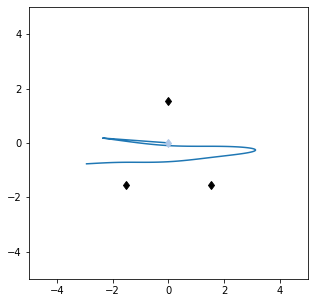

In [122]:
print(f'Predicted Charges: {predicted_charges[indices[0]].detach()}, Actual Charges: {charges_test[indices[0]]}')
print(f'The length of the given sequence: {((simulation_test[indices[0]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[0]])

Predicted Charges: tensor([-0.7961, -0.3833, -0.8149]), Actual Charges: tensor([-0.7817, -0.3412, -0.8381])
The length of the given sequence: 97


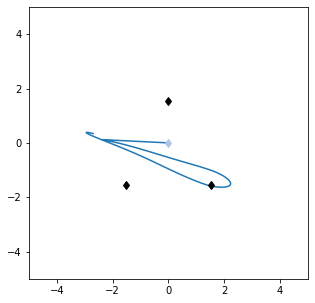

In [123]:
print(f'Predicted Charges: {predicted_charges[indices[1]].detach()}, Actual Charges: {charges_test[indices[1]]}')
print(f'The length of the given sequence: {((simulation_test[indices[1]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[1]])

Predicted Charges: tensor([-0.1276, -0.1210, -0.6010]), Actual Charges: tensor([-0.0863, -0.1648, -0.5565])
The length of the given sequence: 101


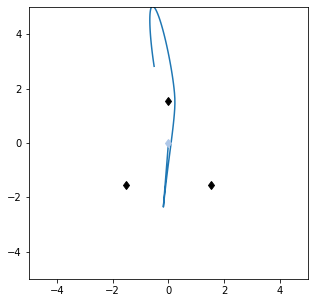

In [124]:
print(f'Predicted Charges: {predicted_charges[indices[2]].detach()}, Actual Charges: {charges_test[indices[2]]}')
print(f'The length of the given sequence: {((simulation_test[indices[2]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[2]])

Predicted Charges: tensor([-0.4362, -0.7509, -0.1679]), Actual Charges: tensor([-0.3213, -0.7681, -0.1656])
The length of the given sequence: 98


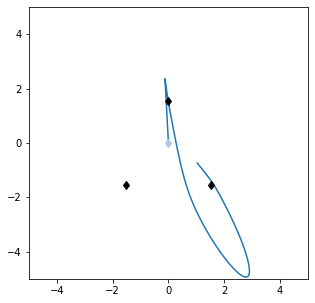

In [125]:
print(f'Predicted Charges: {predicted_charges[indices[3]].detach()}, Actual Charges: {charges_test[indices[3]]}')
print(f'The length of the given sequence: {((simulation_test[indices[3]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[3]])

Predicted Charges: tensor([-0.5627, -0.6754, -0.7150]), Actual Charges: tensor([-0.5768, -0.7467, -0.7766])
The length of the given sequence: 94


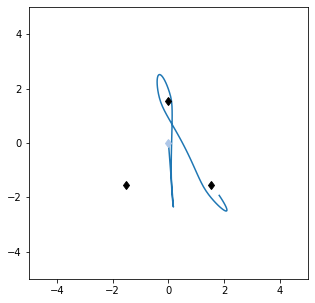

In [126]:
print(f'Predicted Charges: {predicted_charges[indices[4]].detach()}, Actual Charges: {charges_test[indices[4]]}')
print(f'The length of the given sequence: {((simulation_test[indices[4]] != 0).sum(axis = 1) > 0).sum().item()}')
plot_example(simulation_test[indices[4]])

# Task 3.2

## Model Implementation

In [171]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
        self.embedding = nn.Sequential(nn.Linear(coord_shape, emb_dim),
                                       nn.Dropout(dropout))
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first = True)
        
    def forward(self, x):
        
        x = self.embedding(x)
        _, (hidden, cell) = self.rnn(x)

        return hidden, cell

In [172]:
class Decoder(nn.Module):
    def __init__(self, input_shape, hid_dim, n_layers, dropout):
        super(Decoder, self).__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_shape, hid_dim, n_layers, dropout=dropout, batch_first = True)

    def forward(self, x, hidden, cell):
        
        output, (hidden, cell) = self.rnn(x, (hidden, cell))

        return output, (hidden, cell)

In [173]:
import numpy as np 

class Seq2SeqARG(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout, device = torch.device('cpu')):
        super(Seq2SeqARG, self).__init__()
        self.device = device

        self.encoder = Encoder(coord_shape, emb_dim, hid_dim, n_layers, dropout)

        self.decoder = Decoder(input_shape=coord_shape, hid_dim=hid_dim, n_layers=n_layers, dropout=dropout)

        self.dense = nn.Sequential(nn.Linear(hid_dim, 128),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(128, coord_shape))
                                  
    def forward(self, particle_trajectory, target_trajectory, teacher_forcing_ratio = 0.5):
        
        hidden, cell = self.encoder(particle_trajectory)
        
        hidden = hidden[:,0,:]
        cell = cell[:,0,:]

        predicted_target = torch.zeros((target_trajectory.shape)).to(self.device)

        previous = particle_trajectory[:,-1,:]
        for t in range(0, target_trajectory.shape[1]):
            
            output, (hidden, cell) = self.decoder(previous, hidden, cell)
            # output = (batch_size, 1, hid_dim)

            predicted_target[:,t] = self.dense(output)

            # ground truth usage
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.rand(1)[0] > teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = target_trajectory[:,t]

            previous = predicted_target[:,t ] if teacher_force else top1
        
        return predicted_target

## Model Training

In [174]:
class Trainer32():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y, z in self.training_DataLoader:

                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device) # send to device (GPU or CPU)
                

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                # out - (batch_size, sequence_length, coordinates)
                out = self.model(x_sequence, y_sequence)  # one forward pass

                #for pred,actual,seq_len in zip(out, y_sequence, lengths):

                #    loss += self.criterion(pred[:seq_len], actual[:seq_len])  # calculate loss

                mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                loss += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1))
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x, y, z in self.validation_DataLoader:

                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(x_sequence, y_sequence)  # one forward pass
                    
                    mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                    loss += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1) ) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self):

        self.model.eval()

        with torch.no_grad():
            loss = []
            length = 0
            for x,y,z in self.testing_DataLoader:
                
                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device)
                out = self.model(x_sequence, y_sequence, 0)
                loss_batch = 0
                mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                loss_batch += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1)) 

                loss.append(loss_batch)
        print(f'Error: {np.mean(loss):.4f}')

## Evaluation

Train with 0.5 probability of teacher force

Evaluation is always without teacher force

In [175]:
if torch.cuda.is_available():
        device = torch.device('cuda')
else:
        device=torch.device('cpu')

model = Seq2SeqARG(coord_shape = 2, emb_dim = 8, hid_dim = 16, n_layers = 1, dropout = 0.5).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer32(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader_32,
                                valid_dataloader_32,
                                test_dataloader_32,
                                epochs = 30)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()

  3%|██▊                                                                                | 1/30 [00:01<00:52,  1.82s/it]

EPOCH: 01/30 LOSS: 6.1855 VAL-LOSS: 6.4961


  7%|█████▌                                                                             | 2/30 [00:03<00:49,  1.76s/it]

EPOCH: 02/30 LOSS: 5.8739 VAL-LOSS: 5.8921


 10%|████████▎                                                                          | 3/30 [00:05<00:48,  1.80s/it]

EPOCH: 03/30 LOSS: 4.8474 VAL-LOSS: 4.9471


 13%|███████████                                                                        | 4/30 [00:07<00:46,  1.80s/it]

EPOCH: 04/30 LOSS: 4.0783 VAL-LOSS: 3.6138


 17%|█████████████▊                                                                     | 5/30 [00:09<00:47,  1.90s/it]

EPOCH: 05/30 LOSS: 2.8782 VAL-LOSS: 2.3263


 20%|████████████████▌                                                                  | 6/30 [00:11<00:45,  1.91s/it]

EPOCH: 06/30 LOSS: 1.5452 VAL-LOSS: 1.8750


 23%|███████████████████▎                                                               | 7/30 [00:13<00:44,  1.95s/it]

EPOCH: 07/30 LOSS: 1.4862 VAL-LOSS: 1.0753


 27%|██████████████████████▏                                                            | 8/30 [00:15<00:42,  1.95s/it]

EPOCH: 08/30 LOSS: 1.2312 VAL-LOSS: 1.1178


 30%|████████████████████████▉                                                          | 9/30 [00:17<00:41,  1.96s/it]

EPOCH: 09/30 LOSS: 1.0807 VAL-LOSS: 1.3566


 33%|███████████████████████████▎                                                      | 10/30 [00:19<00:40,  2.01s/it]

EPOCH: 10/30 LOSS: 1.1880 VAL-LOSS: 1.4135


 37%|██████████████████████████████                                                    | 11/30 [00:21<00:38,  2.00s/it]

EPOCH: 11/30 LOSS: 0.9653 VAL-LOSS: 0.9598


 40%|████████████████████████████████▊                                                 | 12/30 [00:23<00:35,  1.97s/it]

EPOCH: 12/30 LOSS: 1.2057 VAL-LOSS: 0.9889


 43%|███████████████████████████████████▌                                              | 13/30 [00:25<00:33,  1.98s/it]

EPOCH: 13/30 LOSS: 0.8918 VAL-LOSS: 0.9363


 47%|██████████████████████████████████████▎                                           | 14/30 [00:27<00:31,  1.95s/it]

EPOCH: 14/30 LOSS: 0.9644 VAL-LOSS: 0.9521


 50%|█████████████████████████████████████████                                         | 15/30 [00:28<00:28,  1.91s/it]

EPOCH: 15/30 LOSS: 0.9218 VAL-LOSS: 0.9153


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:30<00:26,  1.90s/it]

EPOCH: 16/30 LOSS: 0.6722 VAL-LOSS: 1.0110


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:32<00:24,  1.91s/it]

EPOCH: 17/30 LOSS: 0.8990 VAL-LOSS: 0.6378


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:34<00:23,  1.95s/it]

EPOCH: 18/30 LOSS: 0.7566 VAL-LOSS: 0.7565


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:36<00:21,  1.93s/it]

EPOCH: 19/30 LOSS: 0.7399 VAL-LOSS: 0.7239


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:38<00:19,  1.92s/it]

EPOCH: 20/30 LOSS: 0.7196 VAL-LOSS: 0.6391


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:40<00:17,  1.94s/it]

EPOCH: 21/30 LOSS: 0.6704 VAL-LOSS: 0.7357


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:42<00:16,  2.02s/it]

EPOCH: 22/30 LOSS: 0.7549 VAL-LOSS: 0.7704


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:45<00:14,  2.12s/it]

EPOCH: 23/30 LOSS: 0.6598 VAL-LOSS: 0.5468


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:47<00:13,  2.26s/it]

EPOCH: 24/30 LOSS: 0.7311 VAL-LOSS: 0.6128


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:49<00:11,  2.28s/it]

EPOCH: 25/30 LOSS: 0.6134 VAL-LOSS: 0.7296


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:52<00:08,  2.24s/it]

EPOCH: 26/30 LOSS: 0.6799 VAL-LOSS: 0.5728


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:54<00:06,  2.18s/it]

EPOCH: 27/30 LOSS: 0.5405 VAL-LOSS: 0.4812


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:56<00:04,  2.12s/it]

EPOCH: 28/30 LOSS: 0.6152 VAL-LOSS: 0.4177


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:58<00:02,  2.09s/it]

EPOCH: 29/30 LOSS: 0.5816 VAL-LOSS: 0.6341


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:00<00:00,  2.01s/it]

EPOCH: 30/30 LOSS: 0.6460 VAL-LOSS: 0.6471


Error: 5.7712


-----

### Linear interpolation

In [176]:
def predict(x):
    prediction = torch.zeros((x.shape[0],60,2))
    diff = (x[:,-1,:] - x[:, -2,:])
    prev = x[:,-1,:]
    for i in range(60):
        prediction[:,i] = prev + (1+i)*diff
    return prediction

In [177]:
with torch.no_grad():
    loss = []
    length = 0
    for x,y,z in test_dataloader_32:

        x_sequence, y_sequence, lengths = x.float(), y.float(), z.float()
        out = predict(x_sequence)
        loss_batch = 0
        mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
        loss_batch += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1)) 

        loss.append(loss_batch)
print(f'Linear Interpolation Error: {np.mean(loss):.4f}')

Linear Interpolation Error: 5.9684


In [183]:
predicted = model(simulation_test, simulation_continued_test, 0).detach()

In [184]:
mask = (torch.arange(60)[None, :] < lengths_test.view(-1)[:, None]).unsqueeze(-1)
metrics = torch.sum((predicted*mask - simulation_continued_test).pow(2), dim=[1,2]) / lengths_test.view(-1)

In [185]:
good_indices = np.argsort(metrics.detach().numpy())[:5]
bad_indices = np.argsort(metrics.detach().numpy())[-5:]

### Good examples

The length of the given sequence: 100 and the length of the prediction is 22.0


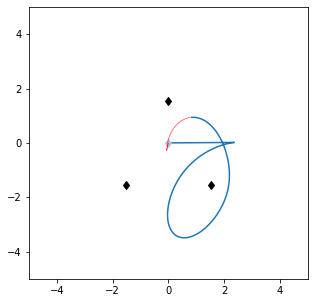

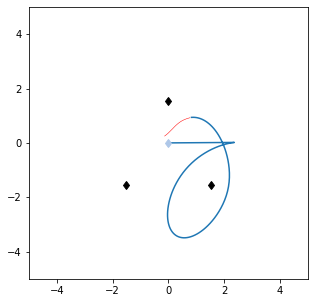

In [191]:
print(f'The length of the given sequence: {((simulation_test[good_indices[0]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[0]].item()}')

plot_example(simulation_test[good_indices[0]], simulation_continued_test[good_indices[0]])
plot_example(simulation_test[good_indices[0]], predicted[good_indices[0]][:int(lengths_test[good_indices[0]].item())])

The length of the given sequence: 98 and the length of the prediction is 21.0


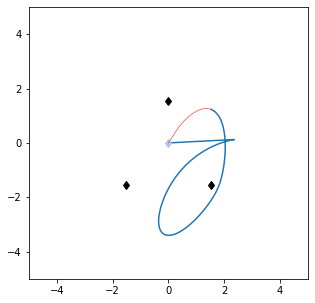

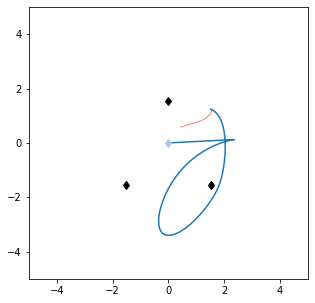

In [192]:
i = 1
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

The length of the given sequence: 104 and the length of the prediction is 23.0


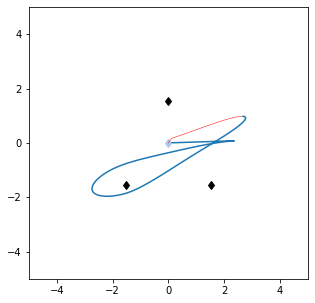

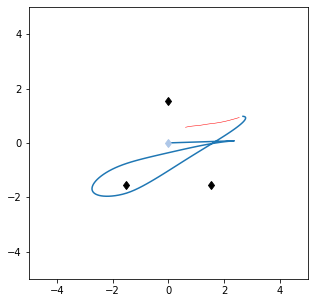

In [193]:
i = 2
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

The length of the given sequence: 98 and the length of the prediction is 25.0


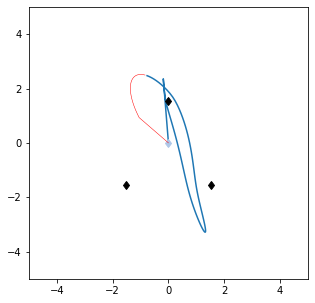

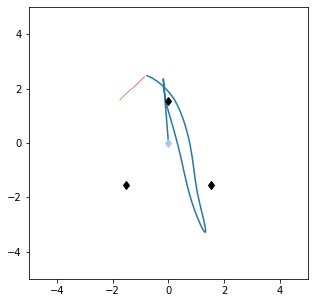

In [194]:
i = 3
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

The length of the given sequence: 97 and the length of the prediction is 22.0


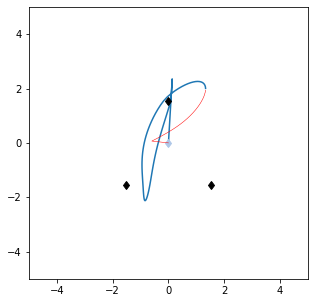

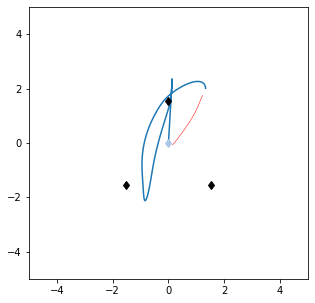

In [195]:
i = 4
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

### Bad examples

The length of the given sequence: 97 and the length of the prediction is 56.0


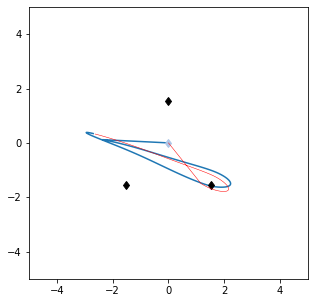

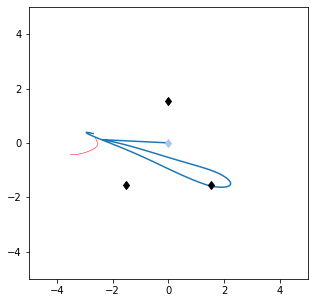

In [196]:
i = 0
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])

The length of the given sequence: 93 and the length of the prediction is 38.0


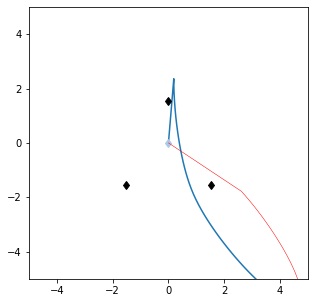

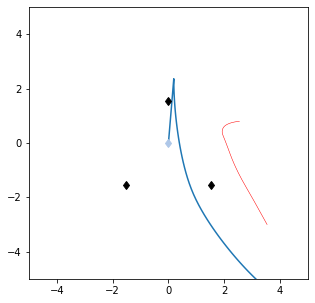

In [197]:
i = 1
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])

The length of the given sequence: 104 and the length of the prediction is 56.0


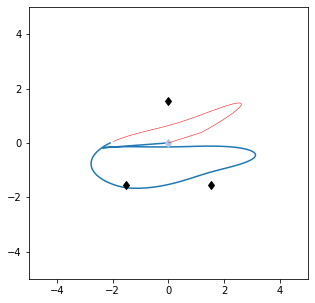

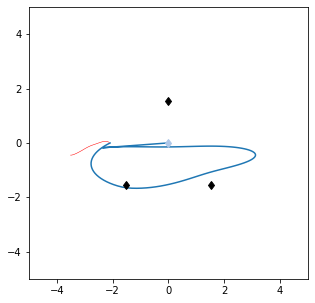

In [198]:
i = 2
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])

The length of the given sequence: 99 and the length of the prediction is 49.0


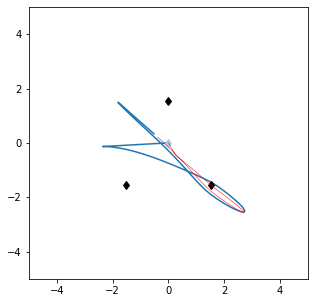

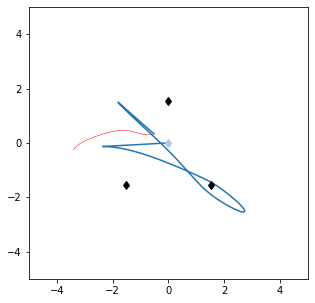

In [199]:
i = 3
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])

The length of the given sequence: 101 and the length of the prediction is 32.0


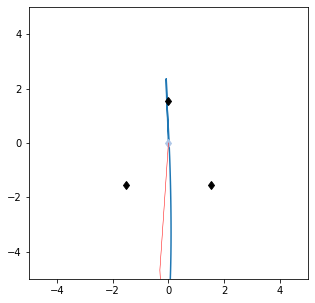

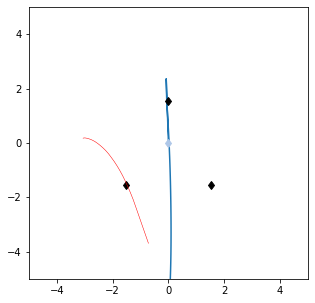

In [201]:
i = 4
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])